In [1]:
# This is the import cell
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
from collections import OrderedDict
from scipy import stats
from PIL import Image
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
first = True
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 10)

# Here are my rc parameters for matplotlib
fsize = 10
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': fsize})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 2000
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5
# Set x tick params
mpl.rcParams['xtick.major.size'] = 4.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.minor.width'] = 1.25
# Set y tick params
mpl.rcParams['ytick.major.size'] = 4.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.minor.width'] = 1.25
# Load LaTeX and amsmath
# mpl.rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
# Get your text data to overlay
if first:
    parent = os.getcwd()
os.chdir(parent)

# Grab file names from data folder
comp = os.listdir('../comp_txt')
try:
    comp.remove('.DS_Store')
except:
    print(".DS_Store not in directory")

In [3]:
# Some functions to get the relevant data from the filenames
def checkFile(fname, string):
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
#             print"{} matches {}".format(fname[i], string[0])
            for j in xrange(1, len(string)):
                if (i + j) > (len(fname) - 1):
                    break
                elif fname[i + j] == string[j]:
#                     print"{} matches {}".format(fname[i+j], string[j])
                    if j == (len(string) - 1):
#                         print"Final match!"
                        return True
                else:
                    break
    return False
    
def txtValue(fname, string):
    out = ""
    index = 0
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
            for j in xrange(1, len(string)):
                if (i + j) > (len(fname) - 1):
                    break
                elif fname[i + j] == string[j]:
                    if j == (len(string) - 1):
                        # Last index of search string
                        index = i + j
                else:
                    break
                        
    # First index of value
    index += 1
    mybool = True
    while mybool:
        if fname[index].isdigit():
            out = out + fname[index]
            index += 1
        elif fname[index] == ".":    
            if fname[index+1].isdigit():
                out = out + fname[index]
                index += 1
            else:
                mybool = False
        else:
            mybool = False
    return float(out)

# Sorting functions
def multiSort(arr1, arr2, arr3, arr4):
    """Sort an array the slow (but certain) way, returns original indices in sorted order"""
    # Doing this for PeR, PeS, xS in this case
    cpy1 = np.copy(arr1)
    cpy2 = np.copy(arr2)
    cpy3 = np.copy(arr3)
    cpy4 = np.copy(arr4)
    ind = np.arange(0, len(arr1))
    for i in xrange(len(cpy1)):
        for j in xrange(len(cpy1)):
            # Sort by first variable
            if cpy1[i] > cpy1[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                cpy4[i], cpy4[j] = cpy4[j], cpy4[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            # If first variable is equal, resort to second variable
            elif cpy1[i] == cpy1[j] and cpy2[i] > cpy2[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                cpy4[i], cpy4[j] = cpy4[j], cpy4[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] > cpy3[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                cpy4[i], cpy4[j] = cpy4[j], cpy4[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] == cpy3[j] and cpy4[i] > cpy4[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                cpy4[i], cpy4[j] = cpy4[j], cpy4[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
    return ind

def indSort(arr1, arr2):
    """Take sorted index array, use to sort array"""
    # arr1 is array to sort
    # arr2 is index array
    cpy = np.copy(arr1)
    for i in xrange(len(arr1)):
        arr1[i] = cpy[arr2[i]]

In [4]:
# Grab parameters, sort them
chkStrings = ["pe", "pa", "pb", "xa", "eps", "phi", "cluster", "dtau"]
default = [0., 0., 0., 0.5, 1., 60., 0, 0.000001]
storeVals = [[] for i in chkStrings]
for i in comp:
    for j in range(0, len(chkStrings)):
        if chkStrings[j] != "cluster":
            if checkFile(i, chkStrings[j]):
                storeVals[j].append(txtValue(i, chkStrings[j]))
            else:
                storeVals[j].append(default[j])  
        else:
            if checkFile(i, chkStrings[j]):
                storeVals[j].append(1)
            else:
                storeVals[j].append(default[j]) 
                
# Issue with epsilon in file output 0 -> 0.0001
for i in range(0, len(storeVals[4])):
    if storeVals[4][i] == 0.0:
        storeVals[4][i] = 0.0001

# Sort the arrays
if len(storeVals[0]) > 1:
    # Sort them!
#     print("Sorting... ")
    # Sort by: pe, phi, epsilon, cluster
    indArr = multiSort(storeVals[chkStrings.index("pa")],
                       storeVals[chkStrings.index("pb")],
                       storeVals[chkStrings.index("eps")],
                       storeVals[chkStrings.index("cluster")])
    indSort(comp, indArr)
    for i in storeVals:
        indSort(i, indArr)
    
# Now that the data is sorted, read it into a dataframe
all_comp = []
os.chdir(parent)
os.chdir('../comp_txt')
for i in comp:
    print(i)
    df = pd.read_csv(i, sep='\s+', header=0)
    display(df)
    all_comp.append(df)
os.chdir(parent)

# This is how you access the data at different levels
display(all_comp[0])

composition_cluster_pa200_pb0_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,19116
1,0.1,81800
2,0.2,77168
3,0.3,75771
4,0.4,71201
...,...,...
164,16.4,56136
165,16.5,54758
166,16.6,56954
167,16.7,56316


composition_cluster_pa200_pb5_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,18040
1,0.1,83949
2,0.2,83699
3,0.3,81655
4,0.4,75413
...,...,...
172,17.2,54469
173,17.3,55708
174,17.4,55864
175,17.5,53136


composition_cluster_pa200_pb10_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,18266
1,0.1,79321
2,0.2,80502
3,0.3,79690
4,0.4,75589
...,...,...
166,16.6,51843
167,16.7,54446
168,16.8,52098
169,16.9,57381


composition_cluster_pa200_pb15_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,18539
1,0.1,83321
2,0.2,79495
3,0.3,74450
4,0.4,27895
...,...,...
139,13.9,55497
140,14.0,55263
141,14.1,56986
142,14.2,54889


composition_cluster_pa200_pb20_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,19144
1,0.1,77366
2,0.2,76389
3,0.3,69200
4,0.4,77767
...,...,...
133,13.3,49026
134,13.4,52665
135,13.5,52838
136,13.6,54654


composition_cluster_pa200_pb30_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,18929
1,0.1,79023
2,0.2,50051
3,0.3,33582
4,0.4,73850
...,...,...
133,13.3,53752
134,13.4,53345
135,13.5,52898
136,13.6,52953


composition_cluster_pa200_pb35_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,19615
1,0.1,70127
2,0.2,66291
3,0.3,48159
4,0.4,25196
...,...,...
129,12.9,51327
130,13.0,52567
131,13.1,48616
132,13.2,51694


composition_cluster_pa200_pb40_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,19354
1,0.1,75588
2,0.2,74482
3,0.3,67617
4,0.4,35421
...,...,...
114,11.4,52191
115,11.5,52372
116,11.6,50665
117,11.7,51776


composition_cluster_pa200_pb45_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,19774
1,0.1,78124
2,0.2,61344
3,0.3,55790
4,0.4,28016
...,...,...
112,11.2,50512
113,11.3,51201
114,11.4,51391
115,11.5,50998


composition_cluster_pa200_pb50_phi60_eps1.0_align3_dtau1.0e-06.txt


,tauB,NinLC
0,0.0,19777
1,0.1,79700
2,0.2,65682
3,0.3,48302
4,0.4,26803
...,...,...
92,9.2,50834
93,9.3,50992
94,9.4,51028
95,9.5,52380


,tauB,NinLC
0,0.0,19116
1,0.1,81800
2,0.2,77168
3,0.3,75771
4,0.4,71201
...,...,...
164,16.4,56136
165,16.5,54758
166,16.6,56954
167,16.7,56316


In [5]:
# Grab the parameters from each file, store in a dataframe
headers = ['pe', 'peA', 'peB', 'xA', 'eps', 'phi', 'peN', 'tauPer_dt']
params = pd.DataFrame(columns=headers)
for i in range(0, len(all_comp)):
    pe = int(storeVals[chkStrings.index("pe")][i])
    pa = int(storeVals[chkStrings.index("pa")][i])
    pb = int(storeVals[chkStrings.index("pb")][i])
    xa = float(storeVals[chkStrings.index("xa")][i])
    ep = float(storeVals[chkStrings.index("eps")][i])
    phi = float(storeVals[chkStrings.index("phi")][i])
    peNet = (pa * (xa)) + (pb * (1.-(xa)))
    dtau = float(storeVals[chkStrings.index("dtau")][i])
    df = pd.DataFrame([[pe, pa, pb, xa, ep, phi, peNet, dtau]], columns=headers)
    params = params.append(df, ignore_index = True)
display(params)

,pe,peA,peB,xA,eps,phi,peN,tauPer_dt
0,0,200,0,0.5,1.0,60.0,100.0,1.0
1,0,200,5,0.5,1.0,60.0,102.5,1.0
2,0,200,10,0.5,1.0,60.0,105.0,1.0
3,0,200,15,0.5,1.0,60.0,107.5,1.0
4,0,200,20,0.5,1.0,60.0,110.0,1.0
5,0,200,30,0.5,1.0,60.0,115.0,1.0
6,0,200,35,0.5,1.0,60.0,117.5,1.0
7,0,200,40,0.5,1.0,60.0,120.0,1.0
8,0,200,45,0.5,1.0,60.0,122.5,1.0
9,0,200,50,0.5,1.0,60.0,125.0,1.0


In [6]:
# All data is loaded, now compute analytical aspects
r_cut = (2.**(1./6.))

# Get lattice spacing for particle size
def ljForce(r, eps, sigma=1.):
    div = (sigma/r)
    dU = (24. * eps / r) * ((2*(div**12)) - (div)**6)
    return dU

# Lennard-Jones pressure
def ljPress(r, eps, sigma=1.):
    # Compute force
    dU = ljForce(r, eps, sigma)
    # This is just pressure divided by the area of a particle
    return (12. * dU / (np.pi * r))

def compPeNet(xf, pes, pef):
    peNet = (pes * (1.-xf)) + (pef * xf)
    return peNet
    
def avgCollisionForce(peNet):
    '''Computed from the integral of possible angles'''
#     peNetCritical = 40.
#     if peNet < peNetCritical:
#         peNet = 0
#     else:
#         peNet -= peNetCritical
    # A vector sum of the six nearest neighbors
    magnitude = np.sqrt(28)
    return (magnitude * peNet) / (np.pi)

def conForRClust(peNet, eps):
    '''Get the lattice spacing for any pe'''
    if peNet == 0:
        return 2.**(1./6.)
    out = []
    r = 2.**(1./6.)
    skip = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    for j in skip:
        while ljForce(r, eps) < avgCollisionForce(peNet):
            r -= j
        r += j
    return r

def latToPhi(latIn):
    '''Read in lattice spacing, output phi'''
    phiCP = np.pi / (2. * np.sqrt(3.))
    return phiCP / (latIn**2)

# From area fraction, get lattice spacing
def phiToLat(phiIn):
    '''Read in phi, output the lattice spacing'''
    phiCP = np.pi / (2. * np.sqrt(3.))
    latCP = 1.
    return np.sqrt(phiCP / phiIn)

def clustFrac(phi, phiG, aF, aS, xF, sig=1.):
    '''Compute the fraction of particles in the cluster'''
    if xF == 0.:
        phiLS = latToPhi(aS)
        phiLF = 1.
    elif xF == 1.:
        phiLS = 1.
        phiLF = latToPhi(aF)
    else:
        phiLS = latToPhi(aS)
        phiLF = latToPhi(aF)
    coeff = (phiG - phi) / phi
    num = phiLF * phiLS
    den = ( phiG * ((phiLS*xF) + (phiLF*(1.-xF))) ) - (phiLF * phiLS)
    ans = coeff * num / den
    return ans

def netClustFrac(phi, phiG, phiL, sig=1.):
    ApL = np.pi * (sig**2) / 4.
    Ap = np.pi * (sig**2) / 4.
    num = (phiL*phiG) - (phiL*phi)
    den = ((ApL/Ap)*phi*phiG) - (phi*phiL)
    ans = num / den
    return ans

def compPhiG(phi, peS, peF, xF, aF, aS, sigma=1., kappa=4.05):
    '''Compute phiG from kinetic theory'''
    num = 3. * sigma * (np.pi**2) * kappa
    den = 4. * ((xF * peF) + ((1.-xF)*peS))
    coef = (xF/aF) + ((1.-xF)/aS) 
#     coef = 1 / ((aF*xF) + (aS*(1.-xF)))
    if den != 0.:
        phiG = coef * (num / den)
    else:
        phiG = phi
    if phiG > phi:
        phiG = phi
    return phiG

def netPhiG(peNet, aNet, kap=5.05, sig=1.):
    num = 3. * (np.pi**2) * kap * sig
    den = 4. * peNet * aNet
    if den == 0:
        phiG = 0.
    else:
        phiG = num / den
    if phiG > 0.6:
        phiG = 0.6
    if phiG < 0.0:
        phiG = 0.0   
    return phiG

# Computations in terms of f*
def fStar(pe, epsilon, sigma=1.):
    out = (avgCollisionForce(pe) * sigma) / (24.*epsilon)
    return out

def nonDimFLJ(r, sigma=1.):
    div = (sigma/r)
    dU = (1. / r) * ((2*(div**12)) - (div)**6)
    return dU

def latForFStar(fstar):
    r = 1.112
    skip = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    for j in skip:
        while nonDimFLJ(r) < fstar:
            r -= j
        r += j
    out = r
    return out

In [7]:
# Let's plot things and see what's happening

# Set range of epsilon
# epsRange = [1., 0.1, 0.01, 0.001, 0.0001]
# epsRange = [10.**-4, 10.**-2, 1.0]
epsRange = [10.**-4, 10.**-2, 10.**-1, 1.0]
epsRange.sort()
epsCols = []
for i in range(0, len(epsRange)):
    epsCols.append(plt.cm.jet(float(i)/len(epsRange)))
    
# Set the range of particle fractions
# xfRange = np.arange(0.0, 1.1, 0.1)
xfRange = [0.3, 0.5, 0.7]
xfRange.sort()
xfCols = []
for i in range(0, len(xfRange)):
    epsCols.append(plt.cm.viridis(float(i)/len(xfRange)))
    
# Set range of Pe S/F
# space = 10.
# pefRange = np.arange(0.0, 500. + space, space)
# pesRange = np.arange(0.0, 500. + space, space)
pesRange = []
pefRange = []
fine = np.arange(0., 50., 1.0) 
coarse = np.arange(60., 505., 5.)
for i in fine:
    pesRange.append(i)
    pefRange.append(i)
for i in coarse:
    pesRange.append(i)
    pefRange.append(i)

N = 100000.
norm = 10.**0.

phiCP = np.pi / (2. * np.sqrt(3))
phi = 0.6
lat = []
latF = []
latS = []
pLJ = []
netcfs = []
cfs = []
Rls = []
netRls = []
peCrit = []
phiGs = []
netPhiGs = []
phiL = []
phiLs = []
phiLf = []
peNets = []

for i in range(0, len(epsRange)):
    # Add index for this epsilon
    lat.append([])
    latF.append([])
    latS.append([])
    pLJ.append([])
    cfs.append([])
    netcfs.append([])
    Rls.append([])
    netRls.append([])
    peCrit.append([])
    phiGs.append([])
    netPhiGs.append([])
    phiL.append([])
    phiLs.append([])
    phiLf.append([])
    peNets.append([])
    for j in range(0, len(xfRange)):
        # Add index for this xf
        lat[i].append([])
        latF[i].append([])
        latS[i].append([])
        pLJ[i].append([])
        cfs[i].append([])
        netcfs[i].append([])
        Rls[i].append([])
        netRls[i].append([])
        peCrit[i].append([])
        phiGs[i].append([])
        netPhiGs[i].append([])
        phiL[i].append([])
        phiLs[i].append([])
        phiLf[i].append([])
        peNets[i].append([])
        for k in range(0, len(pefRange)):
            # Add index for this pef
            lat[i][j].append([])
            latF[i][j].append([])
            latS[i][j].append([])
            pLJ[i][j].append([])
            cfs[i][j].append([])
            netcfs[i][j].append([])
            Rls[i][j].append([])
            netRls[i][j].append([])
            peCrit[i][j].append([])
            phiGs[i][j].append([])
            netPhiGs[i][j].append([])
            phiL[i][j].append([])
            phiLs[i][j].append([])
            phiLf[i][j].append([])
            peNets[i][j].append([])
            for l in range(0, len(pesRange)):
                # Get values, swap if necessary
                cpes = pesRange[l]
                cpef = pefRange[k]
                cxf = xfRange[j]
                if pesRange[l] > pefRange[k]:
                    # Ignore this
                    peNets[i][j][k].append(None)
                    lat[i][j][k].append(None)
                    latF[i][j][k].append(None)
                    latS[i][j][k].append(None)
                    phiL[i][j][k].append(None)
                    phiLf[i][j][k].append(None)
                    phiLs[i][j][k].append(None)
                    pLJ[i][j][k].append(None)
                    phiGs[i][j][k].append(None)
                    netPhiGs[i][j][k].append(None)
                    cfs[i][j][k].append(None)
                    netcfs[i][j][k].append(None)
                    Rls[i][j][k].append(None)
                    netRls[i][j][k].append(None)
                    continue
                    
                # Compute net activity
                peNet = compPeNet(cxf, cpes, cpef)
                peNets[i][j][k].append(peNet)
                
                # Compute lattice spacing (from pe net and individually)
                cLat = conForRClust(peNet, epsRange[i])
                sLat = conForRClust(cpes, epsRange[i])
                fLat = conForRClust(cpef, epsRange[i])
                lat[i][j][k].append(cLat)
                latF[i][j][k].append(fLat)
                latS[i][j][k].append(sLat)
                phiL[i][j][k].append(latToPhi(cLat))
                phiLf[i][j][k].append(latToPhi(fLat))
                phiLs[i][j][k].append(latToPhi(sLat))
                
                # Compute pressure
                cPLJ = ljPress(cLat, epsRange[i])
                pLJ[i][j][k].append(cPLJ)
                
                # Compute phiG
#                 compPhiG(phi, peS, peF, xF, aF, aS, sigma=1., kappa=4.05)
                cphiG = compPhiG(phi, cpes, cpef, cxf, fLat, sLat)
                phiGs[i][j][k].append(cphiG)
    
                # Compute cluster fraction
                if phiGs == phi:
                    ccf = 0.
                else:
                    ccf = clustFrac(phi, cphiG, fLat, sLat, cxf)
                if ccf < 0. or ccf > 1.:
                    ccf = 0.
                cfs[i][j][k].append(ccf)
                
                # Compute net activity-based phiG
                cnetPhiG = netPhiG(peNet, cLat)
                netPhiGs[i][j][k].append(cnetPhiG)
                if cnetPhiG == phi:
                    cncf = 0.
                else:
                    cncf = netClustFrac(phi, cnetPhiG, latToPhi(cLat))
                if cncf < 0. or cncf > 1.:
                    cncf = 0.
                netcfs[i][j][k].append(cncf)
                
                # Compute cluster size
                Nl = ccf * N
                Al = Nl * (np.pi * (cLat**2) * 0.25)
                cRl = np.sqrt(Al / (np.pi))
                Rls[i][j][k].append(cRl)
                
                # Compute cluster size from net quantities
                Nl = cncf * N
                Al = Nl * (np.pi * (cLat**2) * 0.25)
                cRl = np.sqrt(Al / (np.pi))
                netRls[i][j][k].append(cRl)
                
    # This is just to see how fast things are moving along
    print(i)

0
1
2
3


Text(0,0.5,'Cluster fraction $(f_{c})$')

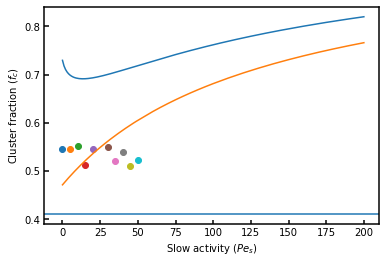

In [8]:
# Let's look at which theory is appropriate

# Constant indices to use
pfi = list(pefRange).index(200.)
xfi = xfRange.index(0.5)
ei = -1

fig = plt.figure()
plt.plot(pesRange, cfs[ei][xfi][pfi])
plt.plot(pesRange, netcfs[ei][xfi][pfi])

# What if we take an average of each monodisperse cluster fraction
monoSlow = cfs[ei][xfi][0][0]
pfi = list(pefRange).index(200.)
psi = list(pesRange).index(200.)
monoFast = cfs[ei][xfi][pfi][psi]
plt.axhline((monoSlow + monoFast) / 2.)
# plt.axhline(netcfs[ei][][][])

for i in range(0, len(comp)):
    plt.scatter(params['peB'][i], all_comp[i]['NinLC'].iloc[-1]/100000.)
    
plt.xlabel(r'Slow activity $(Pe_{s})$')
plt.ylabel(r'Cluster fraction $(f_{c})$')

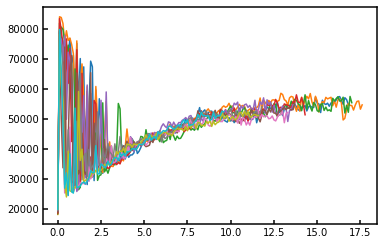

In [9]:
# Let's look at simulation data
for i in range(0, len(all_comp)):
    plt.plot(all_comp[i]['tauB'], all_comp[i]['NinLC'])

In [10]:
# # Let's plot things and see what's happening

# # Set range of epsilon
# # epsRange = [1., 0.1, 0.01, 0.001, 0.0001]
# epsRange = [0.0001, 1.0]
# epsRange.sort()
# epsCols = []
# for i in range(0, len(epsRange)):
#     epsCols.append(plt.cm.jet(float(i)/len(epsRange)))
    
# # Set the range of particle fractions
# # xfRange = np.arange(0.0, 1.1, 0.1)
# xfRange = [0.1, 0.5, 0.9]
# xfRange.sort()
# xfCols = []
# for i in range(0, len(xfRange)):
#     epsCols.append(plt.cm.viridis(float(i)/len(xfRange)))
    
# # Set range of Pe S/F
# pefRange = np.arange(0.0, 251.0, 1.0)
# pefRange = [250., 500.]
# pesRange = np.arange(0.0, 251.0, 1.0)
# N = 100000.
# norm = 10.**0.

# phiCP = np.pi / (2. * np.sqrt(3))
# phi = 0.6
# lat = []
# latF = []
# latS = []
# pLJ = []
# cfs = []
# Rls = []
# peCrit = []
# phiGs = []
# phiCPs = []
# peNets = []

# for i in range(0, len(epsRange)):
#     # Add index for this epsilon
#     lat.append([])
#     latF.append([])
#     latS.append([])
#     pLJ.append([])
#     cfs.append([])
#     Rls.append([])
#     peCrit.append([])
#     phiGs.append([])
#     phiCPs.append([])
#     peNets.append([])
#     for j in range(0, len(xfRange)):
#         # Add index for this xf
#         lat[i].append([])
#         latF[i].append([])
#         latS[i].append([])
#         pLJ[i].append([])
#         cfs[i].append([])
#         Rls[i].append([])
#         peCrit[i].append([])
#         phiGs[i].append([])
#         phiCPs[i].append([])
#         peNets[i].append([])
#         for k in range(0, len(pefRange)):
#             # Add index for this pef
#             lat[i][j].append([])
#             latF[i][j].append([])
#             latS[i][j].append([])
#             pLJ[i][j].append([])
#             cfs[i][j].append([])
#             Rls[i][j].append([])
#             peCrit[i][j].append([])
#             phiGs[i][j].append([])
#             phiCPs[i][j].append([])
#             peNets[i][j].append([])
#             for l in range(0, len(pesRange)):
#                 # Get values, swap if necessary
#                 cpes = pesRange[l]
#                 cpef = pefRange[k]
#                 cxf = xfRange[j]
#                 if pesRange[l] > pefRange[k]:
#                     cpes = pefRange[k]
#                     cpef = pesRange[l]
#                     cxf = 1. - xfRange[j]
#                 # Compute net activity
#                 peNet = compPeNet(cxf, cpes, cpef)
#                 peNets[i][j][k].append(peNet)
                
#                 # Compute lattice spacing (from pe net and individually)
#                 cLat = conForRClust(peNet, epsRange[i])
#                 sLat = conForRClust(cpes, epsRange[i])
#                 fLat = conForRClust(cpef, epsRange[i])
#                 lat[i][j][k].append(cLat)
#                 latF[i][j][k].append(fLat)
#                 latS[i][j][k].append(sLat)
                
#                 # Compute pressure
#                 cPLJ = ljPress(cLat, epsRange[i])
#                 pLJ[i][j][k].append(cPLJ)
                
#                 # Compute phiG
# #                 compPhiG(phi, peS, peF, xF, aF, aS, sigma=1., kappa=4.05)
#                 cphiG = compPhiG(phi, cpes, cpef, cxf, fLat, sLat)
#                 phiGs[i][j][k].append(cphiG)
    
#                 # Compute cluster fraction
#                 if phiGs == phi:
#                     ccf = 0.
#                 else:
#                     ccf = clustFrac(phi, cphiG, fLat, sLat, cxf)
#                 if ccf < 0. or ccf > 1.:
#                     ccf = 0.
#                 cfs[i][j][k].append(ccf)
                
#                 # Compute cluster size
#                 Nl = ccf * N
#                 Al = Nl * (np.pi * (cLat**2) * 0.25)
#                 cRl = np.sqrt(Al / (np.pi))
#                 Rls[i][j][k].append(cRl)
#     # This is just to see how fast things are moving along
#     print(i)

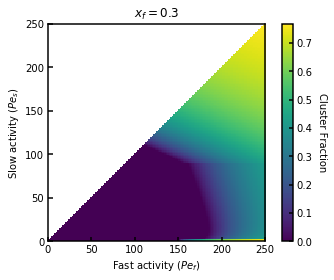

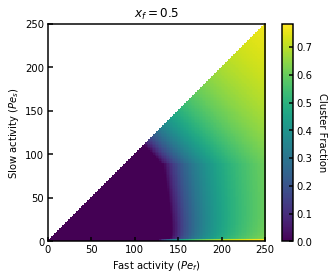

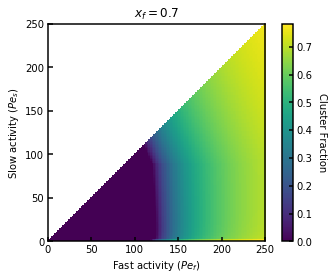

In [11]:
# Let's loop through xF to show how this effects mixtures
for z in range(0, len(xfRange)):
    # Let's look at the cluster fraction (for constant xf and epsilon)    
    pltCF = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    pltPhiG = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    for k in range(0, len(pefRange)):
        for l in range(0, len(pesRange)):
            pltCF[k][l] = cfs[0][z][k][l]
            pltPhiG[k][l] = phiGs[0][z][k][l]
    # Plot the heatmap you've made
#     print(np.amax(pltCF))
    fig, ax = plt.subplots()
#     im = ax.imshow(pltPhiG.T, origin='lower', extent=(0., 500., 0., 500.))
    im = ax.imshow(pltCF.T, origin='lower', extent=(0., 250., 0., 250.))
    cbar = plt.colorbar(im)
    cbar.set_label(r'Cluster Fraction', rotation=270, labelpad=15)
    ax.set_title(r'$x_{f}=$' + str(xfRange[z]))
    ax.set_xlabel(r'Fast activity $(Pe_{f})$')
    ax.set_ylabel(r'Slow activity $(Pe_{s})$')
    plt.show()
        

eps=0.0001, Pe=17.0
eps=0.01, Pe=17.0
eps=0.1, Pe=15.0
eps=1.0, Pe=11.0


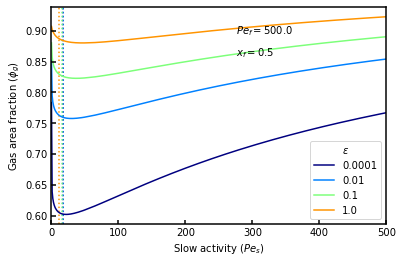

xf=0.3, Pe=11.0
xf=0.5, Pe=17.0
xf=0.7, Pe=23.0


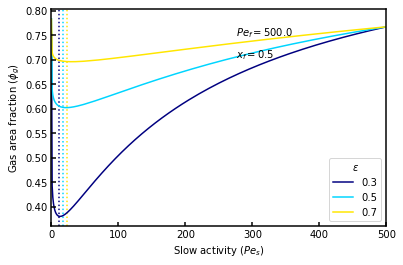

In [12]:
# Prove that the heatmap is actually continuous
kappa = 4.05
sigma = 1.0
ei = 0
xi = xfRange.index(0.5)
pfi = -1

# Index for maximum phiG
mpgi = phiGs[0][xi][pfi].index(max(phiGs[0][xi][pfi]))
maxPe = pesRange[mpgi]

for i in range(0, len(epsRange)):
    plt.plot(pesRange, cfs[i][xi][pfi], c=plt.cm.jet(float(i)/len(epsRange)), label=epsRange[i], zorder=1)
    # Index for maximum phiG
    mpgi = phiGs[i][xi][pfi].index(max(phiGs[i][xi][pfi]))
    maxPe = pesRange[mpgi]
    print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    plt.axvline(maxPe, c=plt.cm.jet(float(i)/len(epsRange)), zorder=0, ls=':')
    
ax = plt.gca()
plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
plt.text(x=0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.legend(title=r'$\epsilon$')
plt.xlim(min(pesRange), max(pesRange))
plt.xlabel(r'Slow activity $(Pe_{s})$')
plt.ylabel(r'Gas area fraction $(\phi_{g})$')
plt.show()
    
for i in range(0, len(xfRange)):
    plt.plot(pesRange, cfs[0][i][pfi], c=plt.cm.jet(float(i)/len(xfRange)), label=xfRange[i], zorder=1)
    # Index for maximum phiG
    mpgi = phiGs[0][i][pfi].index(max(phiGs[0][i][pfi]))
    maxPe = pesRange[mpgi]
    print(r'xf={}, Pe={}').format(xfRange[i], maxPe)
    plt.axvline(maxPe, c=plt.cm.jet(float(i)/len(xfRange)), zorder=0, ls=':')
    
ax = plt.gca()
plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
plt.text(x=0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.legend(title=r'$\epsilon$')
plt.xlim(min(pesRange), max(pesRange))
# plt.ylim(0.1, 0.3)
plt.xlabel(r'Slow activity $(Pe_{s})$')
plt.ylabel(r'Gas area fraction $(\phi_{g})$')
plt.show()


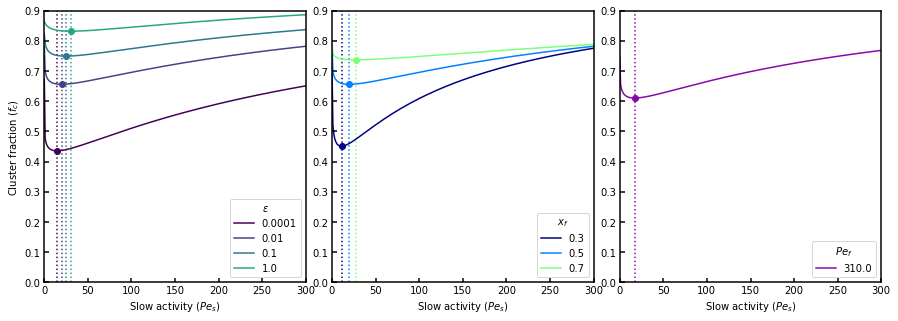

In [13]:
# 1 x 3 plot show effect of eps, xf, pef on location of minimum
fig = plt.figure(figsize=(15, 5))
gs = plt.GridSpec(1, 3, wspace=0.1, figure=fig, width_ratios=[1, 1, 1])
ax = []
# Add axis for each plot
ax.append(plt.subplot(gs[0]))
ax.append(plt.subplot(gs[1]))
ax.append(plt.subplot(gs[2]))

# Constant indices to use
pfi = list(pefRange).index(350.)
xfi = xfRange.index(0.5)
ei = 1

# Loop through and plot varied eps
colshift = 1
for i in range(0, len(epsRange)):
    ax[0].plot(pesRange, cfs[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), label=epsRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[i][xfi][pfi] if x is not None)
    mpgi = cfs[i][xi][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[0].scatter(minpe, mincf, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[0].axvline(minpe, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), zorder=0, ls=':')
    ax[0].set_xlim(min(pesRange), 100.)
    ax[0].set_xlabel(r'Slow activity $(Pe_{s})$')
    ax[0].set_ylabel(r'Cluster fraction $(f_{c})$')
ax[0].legend(title=r'$\epsilon$')
    
# Loop through and plot varied eps
colshift = 1
for i in range(0, len(xfRange)):
    ax[1].plot(pesRange, cfs[ei][i][pfi], c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), label=xfRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[ei][i][pfi] if x is not None)
    mpgi = cfs[ei][i][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[1].scatter(minpe, mincf, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[1].axvline(minpe, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), zorder=0, ls=':')
    ax[1].set_xlim(min(pesRange), 100.)
    ax[1].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[1].legend(title=r'$x_{f}$')
    
# Loop through and plot varied eps
for i in range(100, len(pefRange), 50):
    ax[2].plot(pesRange, cfs[ei][xi][i], c=plt.cm.plasma_r(float(i)/len(pefRange)), label=pefRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[ei][xi][i] if x is not None)
    mpgi = cfs[ei][xi][i].index(mincf)
    minpe = pesRange[mpgi]
    ax[2].scatter(minpe, mincf, c=plt.cm.plasma_r(float(i)/len(pefRange)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[2].axvline(minpe, c=plt.cm.plasma_r(float(i)/len(pefRange)), zorder=0, ls=':')
    ax[2].set_xlim(min(pesRange), 100.)
    ax[2].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[2].legend(title=r'$Pe_{f}$')
    
for i in range(0, len(ax)):
    ax[i].set_xlim(0, 300)
#     ax[i].set_ylim(0, 0.8)
    ax[i].set_ylim(0.0, 0.9)
    
# plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
# plt.text(x=0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.show()

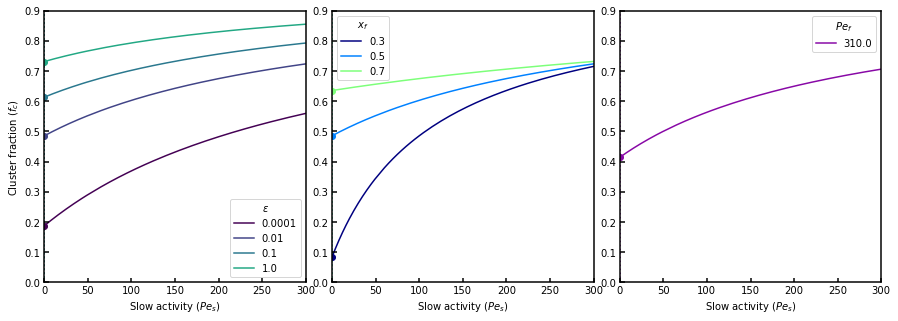

In [14]:
# 1 x 3 plot show effect of eps, xf, pef on location of minimum
fig = plt.figure(figsize=(15, 5))
gs = plt.GridSpec(1, 3, wspace=0.1, figure=fig, width_ratios=[1, 1, 1])
ax = []
# Add axis for each plot
ax.append(plt.subplot(gs[0]))
ax.append(plt.subplot(gs[1]))
ax.append(plt.subplot(gs[2]))

# Constant indices to use
pfi = list(pefRange).index(350.)
xfi = xfRange.index(0.5)
ei = 1

# Loop through and plot varied eps
colshift = 1
for i in range(0, len(epsRange)):
    ax[0].plot(pesRange, netcfs[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), label=epsRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in netcfs[i][xfi][pfi] if x is not None)
    mpgi = netcfs[i][xi][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[0].scatter(minpe, mincf, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[0].axvline(minpe, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), zorder=0, ls=':')
    ax[0].set_xlim(min(pesRange), 100.)
    ax[0].set_xlabel(r'Slow activity $(Pe_{s})$')
    ax[0].set_ylabel(r'Cluster fraction $(f_{c})$')
ax[0].legend(title=r'$\epsilon$')
    
# Loop through and plot varied eps
colshift = 1
for i in range(0, len(xfRange)):
    ax[1].plot(pesRange, netcfs[ei][i][pfi], c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), label=xfRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in netcfs[ei][i][pfi] if x is not None)
    mpgi = netcfs[ei][i][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[1].scatter(minpe, mincf, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[1].axvline(minpe, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), zorder=0, ls=':')
    ax[1].set_xlim(min(pesRange), 100.)
    ax[1].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[1].legend(title=r'$x_{f}$')
    
# Loop through and plot varied eps
for i in range(100, len(pefRange), 50):
    ax[2].plot(pesRange, netcfs[ei][xi][i], c=plt.cm.plasma_r(float(i)/len(pefRange)), label=pefRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in netcfs[ei][xi][i] if x is not None)
    mpgi = netcfs[ei][xi][i].index(mincf)
    minpe = pesRange[mpgi]
    ax[2].scatter(minpe, mincf, c=plt.cm.plasma_r(float(i)/len(pefRange)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[2].axvline(minpe, c=plt.cm.plasma_r(float(i)/len(pefRange)), zorder=0, ls=':')
    ax[2].set_xlim(min(pesRange), 100.)
    ax[2].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[2].legend(title=r'$Pe_{f}$')
    
for i in range(0, len(ax)):
    ax[i].set_xlim(0, 300)
#     ax[i].set_ylim(0, 0.8)
    ax[i].set_ylim(0.0, 0.9)
    
# plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
# plt.text(x=0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.show()

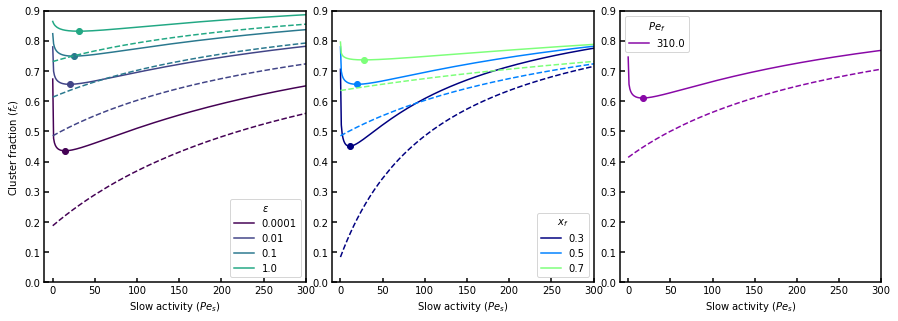

In [15]:
# 1 x 3 plot show effect of eps, xf, pef on location of minimum
fig = plt.figure(figsize=(15, 5))
gs = plt.GridSpec(1, 3, wspace=0.1, figure=fig, width_ratios=[1, 1, 1])
ax = []
# Add axis for each plot
ax.append(plt.subplot(gs[0]))
ax.append(plt.subplot(gs[1]))
ax.append(plt.subplot(gs[2]))

# Constant indices to use
pfi = list(pefRange).index(350.)
xfi = xfRange.index(0.5)
ei = 1

# Loop through and plot varied eps
colshift = 1
for i in range(0, len(epsRange)):
    ax[0].plot(pesRange, netcfs[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)),
               zorder=1, ls='--')
    ax[0].plot(pesRange, cfs[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), label=epsRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[i][xfi][pfi] if x is not None)
    mpgi = cfs[i][xi][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[0].scatter(minpe, mincf, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)))
    ax[0].set_xlim(min(pesRange), 100.)
    ax[0].set_xlabel(r'Slow activity $(Pe_{s})$')
    ax[0].set_ylabel(r'Cluster fraction $(f_{c})$')
ax[0].legend(title=r'$\epsilon$')
    
# Loop through and plot varied eps
colshift = 1
for i in range(0, len(xfRange)):
    ax[1].plot(pesRange, netcfs[ei][i][pfi], c=plt.cm.jet(float(i)/(len(xfRange)+colshift)),
               zorder=1, ls='--')
    ax[1].plot(pesRange, cfs[ei][i][pfi], c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), label=xfRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[ei][i][pfi] if x is not None)
    mpgi = cfs[ei][i][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[1].scatter(minpe, mincf, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)))
    ax[1].set_xlim(min(pesRange), 100.)
    ax[1].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[1].legend(title=r'$x_{f}$')
    
# Loop through and plot varied eps
for i in range(100, len(pefRange), 50):
    ax[2].plot(pesRange, netcfs[ei][xi][i], c=plt.cm.plasma_r(float(i)/len(pefRange)),
               zorder=1, ls='--')
    ax[2].plot(pesRange, cfs[ei][xi][i], c=plt.cm.plasma_r(float(i)/len(pefRange)), label=pefRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[ei][xi][i] if x is not None)
    mpgi = cfs[ei][xi][i].index(mincf)
    minpe = pesRange[mpgi]
    ax[2].scatter(minpe, mincf, c=plt.cm.plasma_r(float(i)/len(pefRange)))
    ax[2].set_xlim(min(pesRange), 100.)
    ax[2].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[2].legend(title=r'$Pe_{f}$')
    
for i in range(0, len(ax)):
    ax[i].set_xlim(-10, 300)
#     ax[i].set_ylim(0, 0.8)
    ax[i].set_ylim(0.0, 0.9)
    
# plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
# plt.text(x =0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.show()

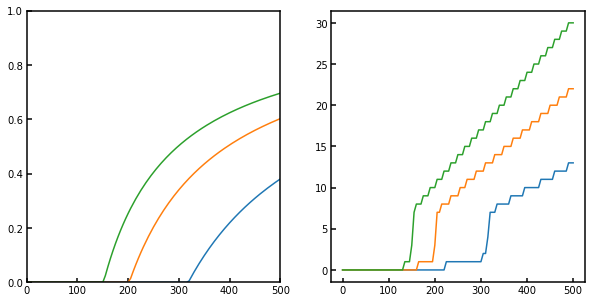

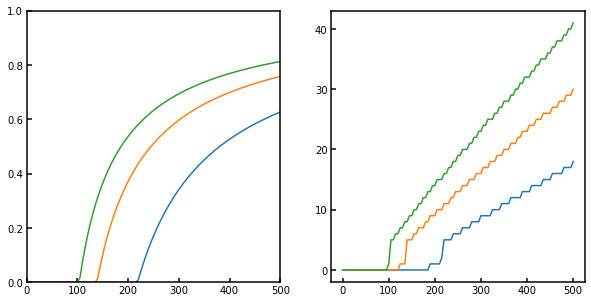

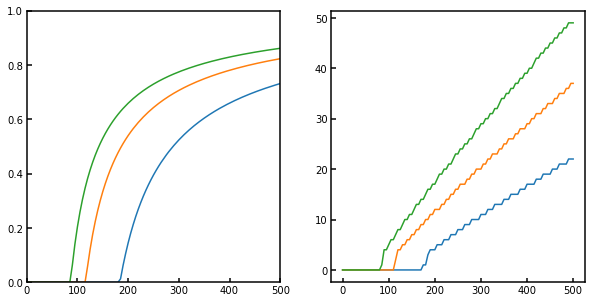

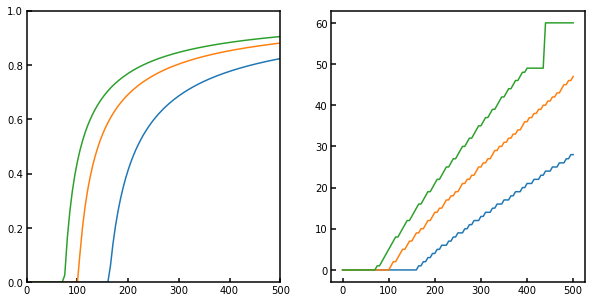

In [16]:
# You should be able to make a list of the minimum in cf for each param
mincfs = []
minpes = []
for i in range(0, len(epsRange)):
    mincfs.append([])
    minpes.append([])
    for j in range(0, len(xfRange)):
        mincfs[i].append([])
        minpes[i].append([])
        for k in range(0, len(pefRange)):
            mincf = min(x for x in cfs[i][j][k] if x is not None)
            mpsi = cfs[i][j][k].index(mincf)
            minpe = pesRange[mpsi]
            mincfs[i][j].append(mincf)
            minpes[i][j].append(minpe)

# Let's look at how the minimum value of cf changes
for i in range(0, len(epsRange)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for j in range(0, len(xfRange)):
        ax[0].plot(pefRange, mincfs[i][j])
        ax[1].plot(pefRange, minpes[i][j])
#         plt.plot(minpes[i][j], mincfs[i][j])
#         plt.xlabel(r'Slow activity at minimum cluster fraction')
#         plt.ylabel(r'Minimum cluster fraction')
#         plt.title(xfRange[j])
#         plt.xlim(0, 50)
#         plt.ylim(0, 1)
    ax[0].set_xlim(0, 500)
    ax[0].set_ylim(0, 1)
    plt.show()
            

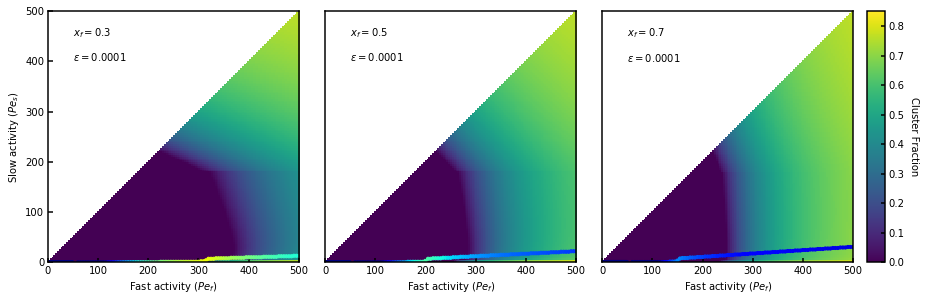

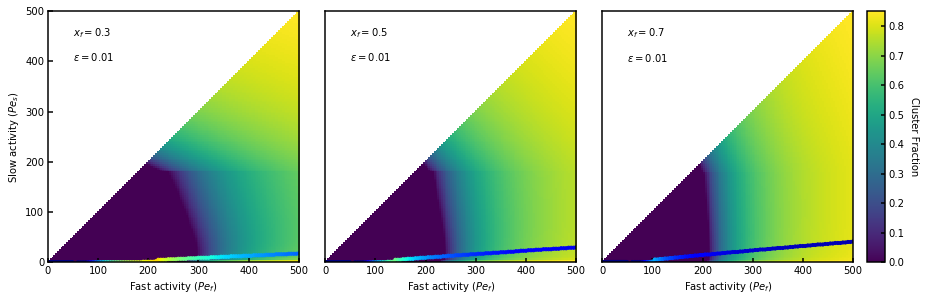

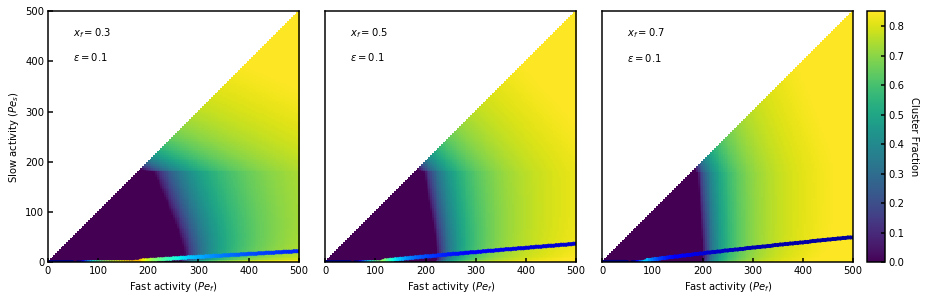

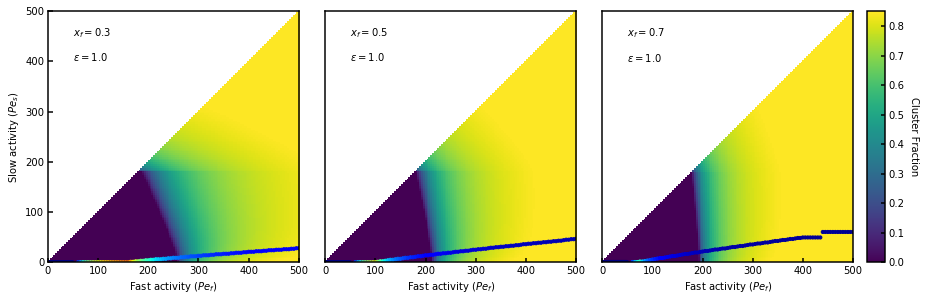

In [17]:
# Convenient plotting function
# A nice function for plotting colorbars
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.2)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

# Let's get the slow activity where cfs is at a minimum for each pef
mincfs = []
mcfmag = []
for i in range(0, len(epsRange)):
    mincfs.append([])
    mcfmag.append([])
    for j in range(0, len(xfRange)):
        mincfs[i].append([])
        mcfmag[i].append([])
        for k in range(0, len(pefRange)):
            # Get the minimum value of cf
            mymin = min(x for x in cfs[i][j][k] if x is not None)
            # Get the maximum value of cf
            mxcf = max(x for x in cfs[i][j][k] if x is not None)
            mcfi = cfs[i][j][k].index(mymin)
            mincfpe = pesRange[mcfi]
            # What is the maximum value of cf at that activity
            mincfs[i][j].append(mincfpe)
#             mcfmag[i][j].append(np.abs(1.-mymin))
            mcfmag[i][j].append(mxcf-mymin)

# Let's loop through xF to show how this effects mixtures
for i in range(0, len(epsRange)):
    fig = plt.figure(figsize=(15, 5))
    gs = plt.GridSpec(nrows=1, ncols=len(xfRange), wspace=0.1, figure=fig, width_ratios=[1, 1, 1.125])
    ax = []
    for j in range(0, len(xfRange)):
        ax.append(plt.subplot(gs[0, j]))
    for j in range(0, len(xfRange)):
        # Let's look at the cluster fraction (for constant xf and epsilon)    
        pltCF = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
        pltPhiG = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
        for k in range(0, len(pefRange)):
            for l in range(0, len(pesRange)):
                pltCF[k][l] = cfs[i][j][k][l]
                pltPhiG[k][l] = phiGs[i][j][k][l]
        # Plot the heatmap you've made
        im = ax[j].imshow(pltCF.T, origin='lower', 
                          extent=(pefRange[0], pefRange[-1], pesRange[0], pesRange[-1]), 
                          vmin=0, vmax=0.85)
        # Plot the minimum in cf
        ax[j].scatter(pefRange, mincfs[i][j], c=plt.cm.jet(mcfmag[i][j]), s=10.0, zorder=2)
        ax[j].text(0.1, 0.8, r'$\epsilon=$' + str(epsRange[i]), transform=ax[j].transAxes)
        ax[j].text(0.1, 0.9, r'$x_{f}=$' + str(xfRange[j]), transform=ax[j].transAxes)
        ax[j].set_xlabel(r'Fast activity $(Pe_{f})$')
        ax[j].set_xlim(0, pefRange[-1])
        ax[j].set_ylim(0, pesRange[-1])
        if j > 0:
            ax[j].set_yticks([])
    ax[0].set_ylabel(r'Slow activity $(Pe_{s})$')    
    cbar = colorbar(im)
    cbar.set_label(r'Cluster Fraction', rotation=270, labelpad=15)
    plt.show()

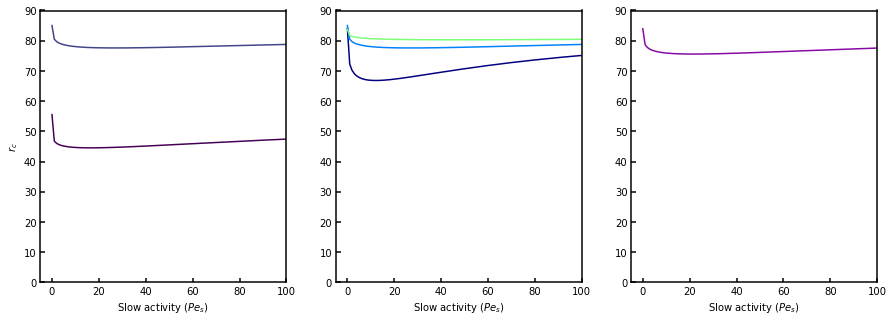

In [18]:
# Let's look at how the minimum value of cf changes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Varied epsilon
for i in range(0, len(epsRange)):
    ax[0].plot(pesRange, Rls[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)))
    
# Varied particle fraction
for j in range(0, len(xfRange)):
    ax[1].plot(pesRange, Rls[ei][j][pfi], c=plt.cm.jet(float(j)/(len(xfRange)+colshift)))

# Varied pe fast
for k in range(100, len(pefRange), 50):
    ax[2].plot(pesRange, Rls[ei][xi][k], c=plt.cm.plasma_r(float(k)/len(pefRange)))
    
for i in range(0, len(ax)):
    ax[i].set_xlim(-5, 100)
    ax[i].set_ylim(0, 90)
    ax[i].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[0].set_ylabel(r'$r_{c}$')
plt.show()
            

In [19]:
# Let's look at the net activity, does the theory predict that it will set the binodal
# for i in range(0, len(epsRange)):
#     for j in range(0, len(xfRange)):
#         for k in range(0, len(pefRange)):
#             for l in range(0, len(pesRange)):
# plt.scatter(peNets, phiL)
# plt.show()
# plt.scatter(peNets, phiLf)
# plt.show()
# plt.scatter(peNets, phiLs)
# plt.show()

In [20]:
# # Let's take a look at phiG
# for i in range(0, len(epsRange)):
#     for j in range(0, len(xfRange)):
#         plt.scatter(peNets[i][j], phiGs[i][j])
#         plt.show()

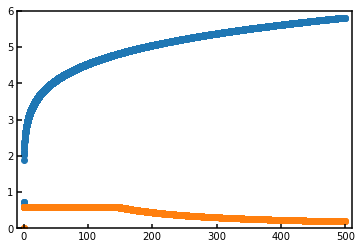

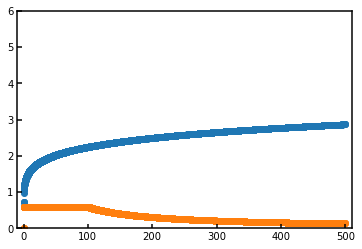

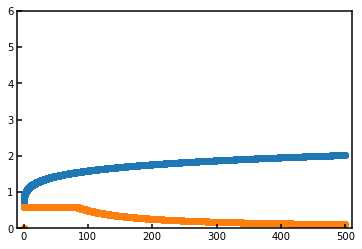

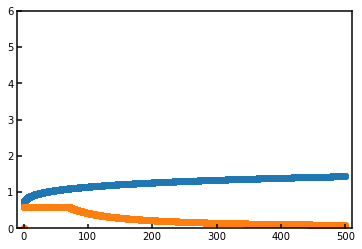

In [21]:
# What does the relationship look like for peNet?
for i in range(0, len(epsRange)):
    plt.scatter(peNets[i], phiL[i])
    plt.scatter(peNets[i], netPhiGs[i])
    plt.xlim(-10, 510)
    plt.ylim(0, 6)
    plt.show()

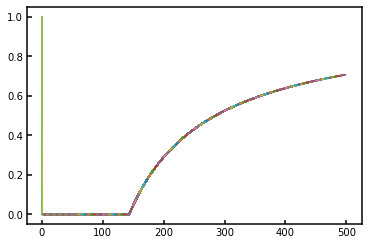

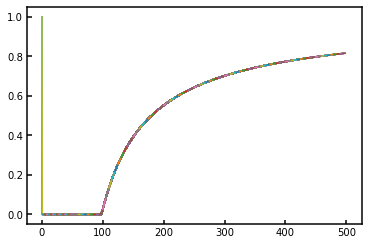

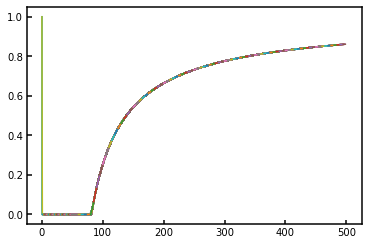

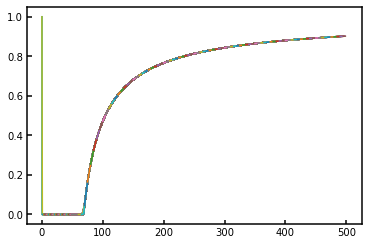

In [22]:
# Let's make plots of quantities with respect to PeNet

# Cluster fraction
for i in range(0, len(epsRange)):
    for j in range(0, len(xfRange)):
#         for k in range(0, len(pefRange)):
        plt.plot(peNets[i][j], netcfs[i][j])
    plt.show()